In [1]:
import sys
import os
if os.getcwd()[:5] == '/rds/':
    sys.path.append('/rds/general/user/ll1917/home/esig/distribution-regression-streams/src') # to add when running on remote Jupyter server
    os.chdir('/rds/general/user/ll1917/home/esig/distribution-regression-streams/martingale-correction-examples') # to add when running on remote Jupyter server
else:
    sys.path.append('../src')

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm

import utils_particles

import SES


import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
ff = 20
params = {'legend.fontsize': ff,
          'figure.figsize': (16, 5),
          'axes.labelsize': ff,
          'axes.titlesize':ff,
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# Task description

The goal is to infer the temperature $T$ of a simulated ideal gas from the trajectories traced by the $N$ particles that compose the gas. The particles evolve in a $3$-d box of fixed volume $V$. The training dataset corresponds to $M$ gases, and is in the form $\{(\{x^{i,j}\}_{j=1}^{N},T_i)\}_{i=1}^{M}$, where $T_i$ is the temperature (in Kelvin) of gas $i$, and $x^{i,j}$ is the $3$-d time-series corresponding to the particle $j$ of gas $i$. 

In this notebook we simulate $M=20$ gases subject to a temperature chosen at random $T\sim\mathcal{U}(1,1000)$. Each gas is composed by $N=20$ particles. We conduct too experiments: 
- **(low number of collisions)** the particles have a small radius $r=0.05\cdot(V/N)^{1/3}$. (precomputed dataset: ./data/low_col_particles.obj)
- **(high number of collisions)** the particles have a bigger radius $r=0.35\cdot(V/N)^{1/3}$. (precomputed dataset: ./data/high_col_particles.obj)

This notebook contains the code to generate new datasets. Alternatively, 2 precomputed datasets can be loaded.

# Gas Properties

In [5]:
R = 6.5 # [3.5, 6.5]

# gas properties
n_particles = 20
V = 3
r = (R/10) * (V/n_particles)**(1./3)
max_time = 2

# Dataset visualization 

In [6]:
# simulation time step
dt = 0.005

# chose the range of temperatures 
temps = [1, 500, 1000]

# simulate gases subject to the temperatures defined above
gases_plot = []
for temp in temps:
    
    Gas = utils_particles.Sim(n_particles, r, temp, V, max_time, dt)

    # To store the trajectories
    trajectories = [[] for i in range(n_particles)]

    for t in np.linspace(0, Gas.max_time, Gas.Nt):
        positions = Gas._draw_frame(t)
        for i in range(len(trajectories)):
            trajectories[i].append(list(positions[i]))
    trajectories = [np.array(particle) for particle in trajectories]

    gases_plot.append(trajectories)

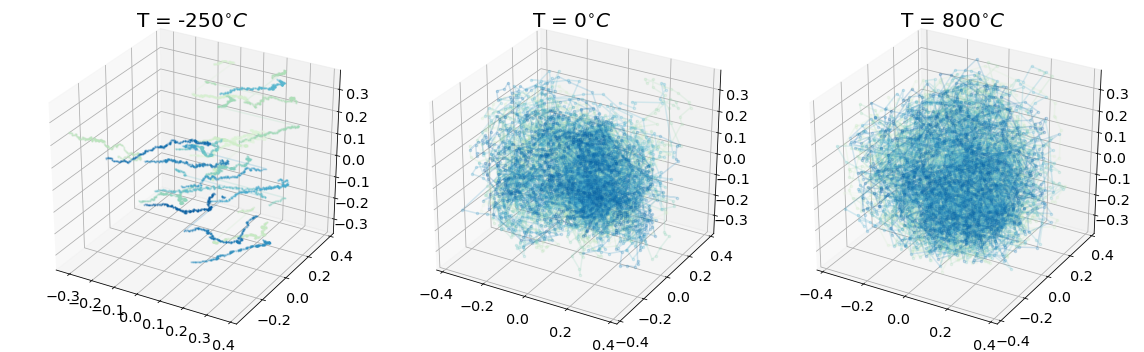

In [7]:
# plot
colors = plt.cm.GnBu(np.linspace(0.1, 0.9, n_particles))
fig = plt.figure()

tt = [-250, 0, 800]

u = 0

for k in range(len(temps)):
    if u==0:
        ss = 1.
    else:
        ss = 2.5
    ax = fig.add_subplot(1, len(temps), k+1, projection='3d')
    for p in range(n_particles):
        ax.plot(gases_plot[k][p][:,0],gases_plot[k][p][:,1],gases_plot[k][p][:,2], alpha=0.2, color=colors[p], 
                marker='o', markersize=ss)
    temp_celsius = tt[k]#temps[k]-273
    ax.set_title(f'T = {temp_celsius}' + '$^{\circ}C$')
    u+=1
    
fig.tight_layout()
#plt.savefig('../pictures/ideal_gas.png')
plt.show()

# Generate data for experiments

**Temperatures**

In [8]:
# how many gases
np.random.seed(0)
M = 50

# temperatures of the M gases
max_T = 1000
min_T = 1
temperatures = np.array((max_T-min_T)*np.random.rand(M)+min_T)

**Simulate $M$ gases**

In [9]:
# simulation time-step
dt = 0.01

gases = []
for temp in tqdm(temperatures):
    
    Gas = utils_particles.Sim(n_particles, r, temp, V, max_time, dt)
    
    # To store the trajectories
    trajectories = [[] for i in range(n_particles)]

    for t in np.linspace(0, Gas.max_time, Gas.Nt):
        positions = Gas._draw_frame(t)
        for i in range(len(trajectories)):
            # update particle i
            trajectories[i].append(list(positions[i]))
    trajectories = [np.array(particle) for particle in trajectories]
    
    gases.append(trajectories)

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


# SES

In [10]:
SES_mse, SES_std_mse, results_SES = SES.model(gases, temperatures/max_T, ll=[0, 1, 2], at=True, depths1=[2, 3], depth2=2, NUM_TRIALS=5, cv=3)

 20%|██        | 1/5 [03:13<12:53, 193.31s/it]

best truncation level (cv on train set):  2


 40%|████      | 2/5 [04:21<07:47, 155.90s/it]

best truncation level (cv on train set):  3


 60%|██████    | 3/5 [05:24<04:15, 127.80s/it]

best truncation level (cv on train set):  2


 80%|████████  | 4/5 [06:31<01:49, 109.61s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [07:35<00:00, 91.16s/it] 

best truncation level (cv on train set):  2


# SES-MC

In [11]:
SES_MC_mse, SES_MC_std_mse, results_SES_MC = SES.model(gases, temperatures/max_T, ll=[0, 1, 2], at=True, depths1=[2, 3], depth2=2, NUM_TRIALS=5, cv=3, martingale_indices=[0, 1, 2])

 20%|██        | 1/5 [00:46<03:05, 46.39s/it]

best truncation level (cv on train set):  3


 40%|████      | 2/5 [01:37<02:23, 47.95s/it]

best truncation level (cv on train set):  3


 60%|██████    | 3/5 [02:30<01:38, 49.18s/it]

best truncation level (cv on train set):  3


 80%|████████  | 4/5 [03:22<00:50, 50.28s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [04:15<00:00, 51.14s/it]

best truncation level (cv on train set):  2


## Results

In [12]:
print(f'SES: {SES_mse} ({SES_std_mse})')
print(f'SES-MC: {SES_MC_mse} ({SES_MC_std_mse})')

SES: 0.0008830693586859191 (0.0002730854247750643)
SES-MC: 0.0007466233718486198 (0.00016777809007680012)


**save results**

In [14]:
import pickle
results = {'SES': results_SES, 'SES-MC': results_SES_MC}
pickle.dump(results, open(f'results/ideal_gas/particles_{R}.pkl','wb'))

# Compare results

In [5]:
import pickle

results_small_R = pickle.load(open(f'results/ideal_gas/particles_3.5.pkl', 'rb'))
results_large_R = pickle.load(open(f'results/ideal_gas/particles_6.5.pkl', 'rb'))

In [6]:
import scipy.stats
import numpy as np

def t_test_mses(results1, results2):
    assert len(results1) == len(results2)
    n = len(results1)
    mses1 = np.zeros(n)
    mses2 = np.zeros(n)
 
    for i in range(n):
        mses1[i]=np.mean((results1[i]['pred'] - results1[i]['true'])**2)
        mses2[i]=np.mean((results2[i]['pred'] - results2[i]['true'])**2)

    t_stat, p_value = scipy.stats.ttest_rel(mses1, mses2)

    return np.mean(mses1), np.std(mses1), np.mean(mses2), np.std(mses2), t_stat, p_value

In [13]:
t_test_results = {}
for R, results in zip([3.5, 6.5], [results_small_R, results_large_R]):
    mse_SES, std_mse_SES, mse_SES_MC, std_mse_SES_MC, t_stat, p_value = t_test_mses(results['SES'], results['SES-MC'])
    t_test_results[f"R={R}"] = [f"{mse_SES*1e2:.2f} ({std_mse_SES*1e2:.2f})", f"{mse_SES_MC*1e2:.2f} ({std_mse_SES_MC*1e2:.2f})", f"{t_stat:.2f}", f"{p_value:.2f}"]

In [14]:
import pandas as pd

df = pd.DataFrame(t_test_results, index=['SES', 'SES-MC', 't-stat', 'p-value'])
df.columns = pd.MultiIndex.from_product([['Predictive MSE [1e-2]'], df.columns])
df

Predictive MSE [1e-2]             
                        R=3.5        R=6.5
SES               1.27 (0.23)  0.09 (0.03)
SES-MC            1.31 (0.45)  0.07 (0.02)
t-stat                  -0.29         1.41
p-value                  0.79         0.23

In [15]:
print(df.to_latex())

\begin{tabular}{lll}
\toprule
{} & \multicolumn{2}{l}{Predictive MSE [1e-2]} \\
{} &                 R=3.5 &        R=6.5 \\
\midrule
SES     &           1.27 (0.23) &  0.09 (0.03) \\
SES-MC  &           1.31 (0.45) &  0.07 (0.02) \\
t-stat  &                 -0.29 &         1.41 \\
p-value &                  0.79 &         0.23 \\
\bottomrule
\end{tabular}

